# # **Project: Interpretable Air Quality Prediction (End-to-End Advanced Analysis)**
# ### **Objective:** To train an XGBoost model, explain its behavior with multi-level SHAP analysis, and demonstrate advanced interpretability techniques.

## **Step 1: Setup and Data Loading**
# We'll import libraries and load our `aqi_dataset.csv`. We will add a simulated 'Hour' column for temporal analysis.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.display import display

# Create necessary directories
if not os.path.exists('results'):
    os.makedirs('results')
    print("Created '/results' directory.")

# Load the realistic dataset
try:
    df = pd.read_csv('aqi_dataset.csv')
    np.random.seed(0)
    df['Hour'] = np.random.randint(0, 24, df.shape[0])
    print("Successfully loaded and prepared 'aqi_dataset.csv'.")
except FileNotFoundError:
    print("Error: 'aqi_dataset.csv' not found.")

print("\nDataset Preview:")
display(df.head())

Created '/results' directory.
Successfully loaded and prepared 'aqi_dataset.csv'.

Dataset Preview:


,Date,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,Year,Month,Day,DayOfWeek,Hour
0,2015-01-01,Delhi,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,2015,1,1,3,12
1,2015-01-02,Delhi,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,2015,1,2,4,15
2,2015-01-03,Delhi,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,2015,1,3,5,21
3,2015-01-04,Delhi,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,2015,1,4,6,0
4,2015-01-05,Delhi,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,2015,1,5,0,3


# ## **Step 2: Model Training and Saving**
# We define our features and target, then train the XGBoost model. Note that 'Hour' is kept with X for later analysis but is NOT used for training.

In [2]:
print("--- Starting Model Training on Realistic Data ---")
# Define features for training
features_to_train = ['PM2.5', 'NO2', 'O3']
X = df[features_to_train]
y = df['AQI']

# Keep 'Hour' for later, aligned with the X data
X_with_hour = df[features_to_train + ['Hour']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"Model Training Complete. RMSE: {rmse:.4f}")

model_path = 'results/aqi_model_final.pkl'
joblib.dump(model, model_path)
print(f"Model saved to '{model_path}'")


--- Starting Model Training on Realistic Data ---


Model Training Complete. RMSE: 82.1649
Model saved to 'results/aqi_model_final.pkl'


## **Step 3: Foundational Explainability (Global Importance)**
# We'll start with the standard SHAP analysis to understand overall feature importance.



--- Starting SHAP Analysis ---



**SHAP Summary Plot (Global Feature Importance):**


C:\Users\Dell\AppData\Local\Temp\ipykernel_13432\3937978616.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, plot_type="dot")


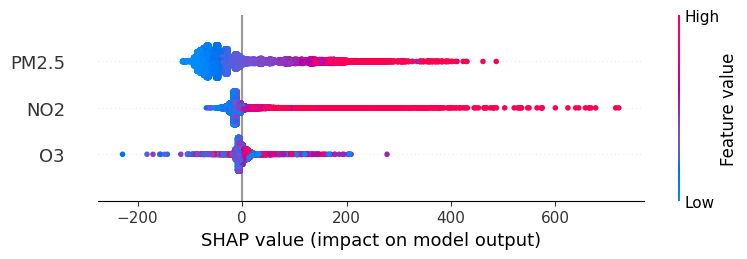

In [3]:
print("\n--- Starting SHAP Analysis ---")
loaded_model = joblib.load('results/aqi_model_final.pkl')
explainer = shap.TreeExplainer(loaded_model)
# Explain the model's predictions on the full feature set
shap_values = explainer(X)

print("\n**SHAP Summary Plot (Global Feature Importance):**")
shap.summary_plot(shap_values, X, plot_type="dot")



## **Step 4: Advanced Analysis - The "How Much?" (Percentage Contribution)**


In [4]:
print("\n--- Advanced Analysis 1: Percentage Contribution ---")
high_aqi_index = y.idxmax()
X_high_instance = X.loc[[high_aqi_index]]
shap_values_high_instance = explainer(X_high_instance)

base_value = shap_values_high_instance.base_values[0]
prediction = loaded_model.predict(X_high_instance)[0]
deviation = prediction - base_value
contribs = shap_values_high_instance.values[0]
total_contrib = np.sum(np.abs(contribs))

print(f"Analysis for a high AQI event (Predicted AQI: {prediction:.2f}):")
print(f"Average Model Prediction (Base Value): {base_value:.2f}")
print(f"Deviation from Average: {deviation:.2f}\n")
print("Percentage Contribution of each pollutant to this deviation:")
for i, feature in enumerate(X.columns):
    percentage = (np.abs(contribs[i]) / total_contrib) * 100
    print(f"- {feature}: {percentage:.2f}%")



--- Advanced Analysis 1: Percentage Contribution ---
Analysis for a high AQI event (Predicted AQI: 1538.11):
Average Model Prediction (Base Value): 166.69
Deviation from Average: 1371.42

Percentage Contribution of each pollutant to this deviation:
- PM2.5: 35.50%
- NO2: 49.39%
- O3: 15.12%


## **Step 5: Advanced Analysis - The "When?" (Temporal Patterns)**
# We investigate if a pollutant's impact changes over the 'Hour' of the day.



--- Advanced Analysis 2: Temporal Patterns ---


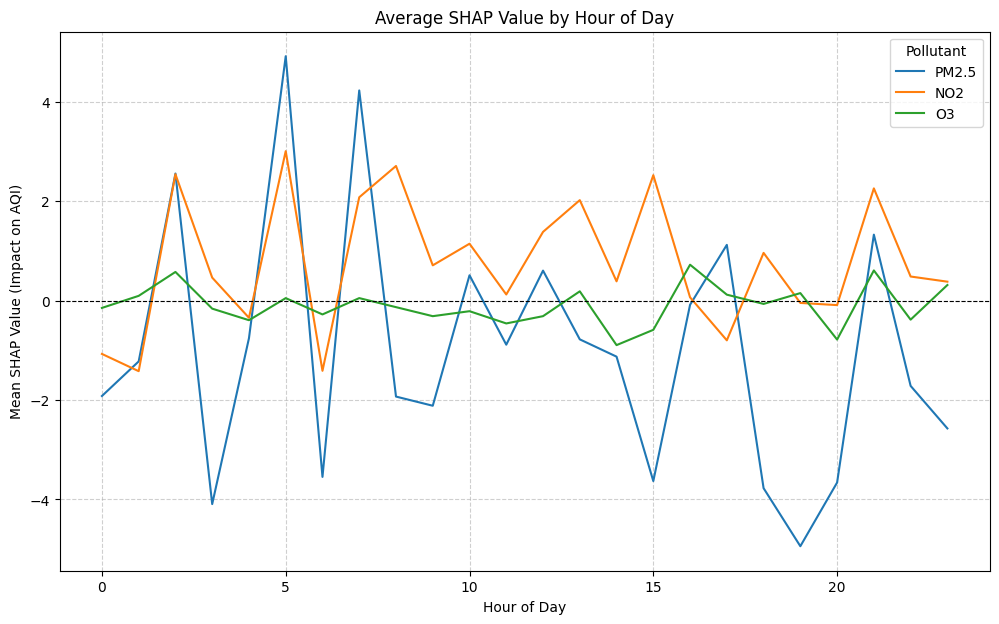

In [5]:
print("\n--- Advanced Analysis 2: Temporal Patterns ---")

# --- FIX IS HERE ---
# The shap_values object has the same index as the X DataFrame it explained.
# We can safely add the 'Hour' column from our original 'df'.
shap_df = pd.DataFrame(shap_values.values, columns=X.columns, index=X.index)
shap_df['Hour'] = df.loc[X.index, 'Hour']
# --- END FIX ---

hourly_mean_shap = shap_df.groupby('Hour').mean()

plt.figure(figsize=(12, 7))
sns.lineplot(data=hourly_mean_shap[features_to_train], dashes=False)
plt.title('Average SHAP Value by Hour of Day')
plt.ylabel('Mean SHAP Value (Impact on AQI)')
plt.xlabel('Hour of Day')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(title='Pollutant')
plt.show()



--- Advanced Analysis 3: Local Explanation (Waterfall Plot) ---
Waterfall plot for the high-AQI prediction:


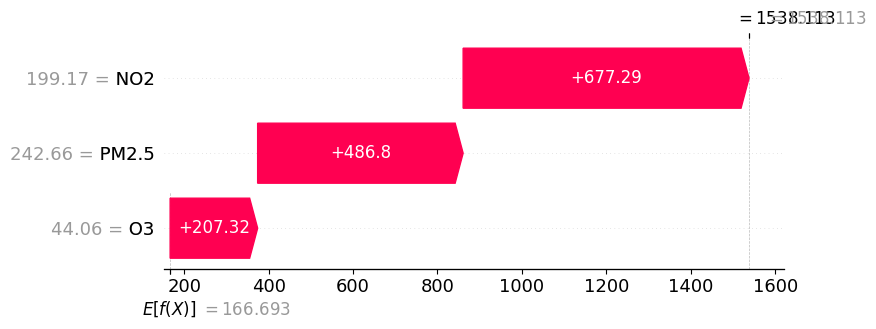

In [6]:
print("\n--- Advanced Analysis 3: Local Explanation (Waterfall Plot) ---")
print("Waterfall plot for the high-AQI prediction:")

shap.plots.waterfall(shap_values_high_instance[0])

